**Model 2: EfficientNet (EfficientNet-B0)**

In [78]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from PIL import Image

In [79]:
# --- Custom Dataset class (using your DataFrames and image folder) ---

class RockPaperScissorsDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = {'rock': 0, 'paper': 1, 'scissors': 2}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[row['class'].lower()]
        if self.transform:
            image = self.transform(image)
        return image, label

In [80]:
# --- Define transforms with random horizontal flip ---

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet normalization stats
                         [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])


In [81]:

train_dataset = RockPaperScissorsDataset(train_df, train_img_dir, transform=train_transform)
val_dataset = RockPaperScissorsDataset(val_df, train_img_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [82]:
# --- Load pretrained EfficientNet-B0 and modify final layer ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNet.from_pretrained('efficientnet-b0')

# Freeze all layers if you want transfer learning only on classification head
for param in model.parameters():
    param.requires_grad = False

# Replace classification head to match 3 classes (rock, paper, scissors)
num_features = model._fc.in_features
model._fc = nn.Linear(num_features, 3)

model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [83]:
# --- Loss function and optimizer ---

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model._fc.parameters(), lr=0.001)  # train only final classification layer

Training and Visualization

Epoch 1/20 - Loss: 1.1003 - Validation Accuracy: 0.4167
Epoch 2/20 - Loss: 1.0097 - Validation Accuracy: 0.4333
Epoch 3/20 - Loss: 0.9602 - Validation Accuracy: 0.4500
Epoch 4/20 - Loss: 0.9042 - Validation Accuracy: 0.4500
Epoch 5/20 - Loss: 0.8545 - Validation Accuracy: 0.4833
Epoch 6/20 - Loss: 0.8189 - Validation Accuracy: 0.5000
Epoch 7/20 - Loss: 0.8041 - Validation Accuracy: 0.4833
Epoch 8/20 - Loss: 0.7784 - Validation Accuracy: 0.5333
Epoch 9/20 - Loss: 0.7472 - Validation Accuracy: 0.5333
Epoch 10/20 - Loss: 0.7147 - Validation Accuracy: 0.5333
Epoch 11/20 - Loss: 0.7218 - Validation Accuracy: 0.5167
Epoch 12/20 - Loss: 0.6991 - Validation Accuracy: 0.5167
Epoch 13/20 - Loss: 0.6943 - Validation Accuracy: 0.5333
Epoch 14/20 - Loss: 0.6439 - Validation Accuracy: 0.5333
Epoch 15/20 - Loss: 0.6037 - Validation Accuracy: 0.5167
Epoch 16/20 - Loss: 0.6030 - Validation Accuracy: 0.4667
Epoch 17/20 - Loss: 0.5914 - Validation Accuracy: 0.5167
Epoch 18/20 - Loss: 0.5997 - Validation 

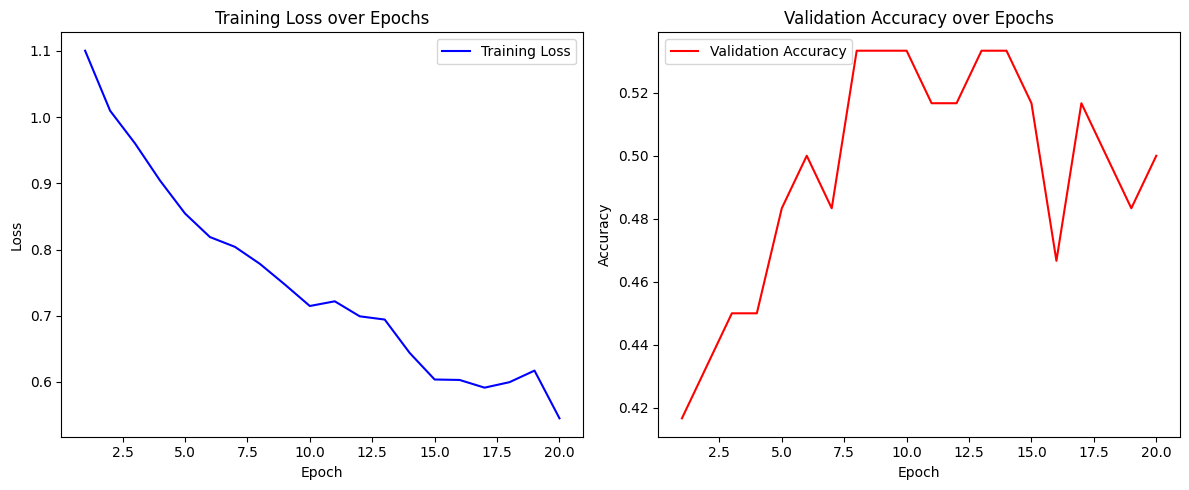

In [84]:
# --- Training and validation loop ---

# Before the training loop
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total

    train_losses.append(epoch_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Validation Accuracy: {val_acc:.4f}")

print("Training complete.")

# Plot learning curves
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Unfreeze all layers in hopes to improve model

Epoch 1/20 - Loss: 0.1208 - Validation Accuracy: 0.6167 - LR: 0.000100
Epoch 2/20 - Loss: 0.0830 - Validation Accuracy: 0.6167 - LR: 0.000100
Epoch 3/20 - Loss: 0.0935 - Validation Accuracy: 0.6333 - LR: 0.000100
Epoch 4/20 - Loss: 0.0485 - Validation Accuracy: 0.6500 - LR: 0.000100
Epoch 5/20 - Loss: 0.0586 - Validation Accuracy: 0.6833 - LR: 0.000100
Epoch 6/20 - Loss: 0.0427 - Validation Accuracy: 0.6833 - LR: 0.000100
Epoch 7/20 - Loss: 0.0306 - Validation Accuracy: 0.6500 - LR: 0.000010
Epoch 8/20 - Loss: 0.0330 - Validation Accuracy: 0.6333 - LR: 0.000010
Epoch 9/20 - Loss: 0.0337 - Validation Accuracy: 0.6333 - LR: 0.000010
Epoch 10/20 - Loss: 0.0203 - Validation Accuracy: 0.6500 - LR: 0.000010
Epoch 11/20 - Loss: 0.0379 - Validation Accuracy: 0.6500 - LR: 0.000010
Epoch 12/20 - Loss: 0.0458 - Validation Accuracy: 0.6500 - LR: 0.000010
Epoch 13/20 - Loss: 0.0203 - Validation Accuracy: 0.6500 - LR: 0.000010
Epoch 14/20 - Loss: 0.0193 - Validation Accuracy: 0.6500 - LR: 0.000001
E

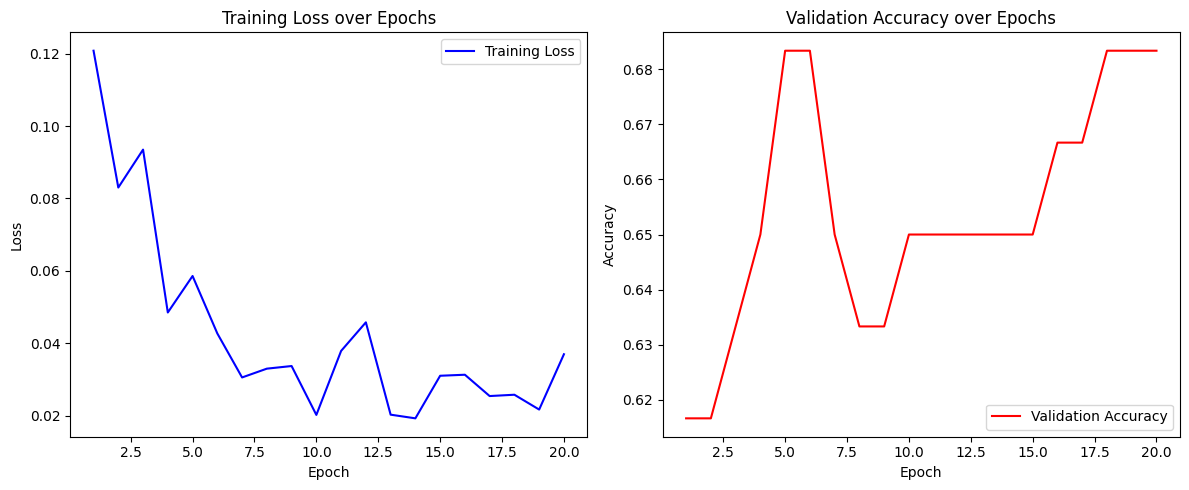

In [87]:
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Setup optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Define learning rate scheduler: reduce LR by factor 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total

    # Update learning rate
    scheduler.step()

    train_losses.append(epoch_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Validation Accuracy: {val_acc:.4f} - LR: {scheduler.get_last_lr()[0]:.6f}")

# Plotting training loss and validation accuracy after training
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/20 - Train Loss: 0.0250 - Val Loss: 0.8936 - Val Accuracy: 0.6500 - LR: 0.000100
Epoch 2/20 - Train Loss: 0.0204 - Val Loss: 0.9870 - Val Accuracy: 0.6833 - LR: 0.000100
Epoch 3/20 - Train Loss: 0.0228 - Val Loss: 1.0084 - Val Accuracy: 0.7167 - LR: 0.000100
Epoch 4/20 - Train Loss: 0.0177 - Val Loss: 1.0547 - Val Accuracy: 0.6833 - LR: 0.000100
Epoch 5/20 - Train Loss: 0.0279 - Val Loss: 1.1029 - Val Accuracy: 0.6833 - LR: 0.000100
Epoch 6/20 - Train Loss: 0.0217 - Val Loss: 1.0902 - Val Accuracy: 0.6500 - LR: 0.000100
Epoch 7/20 - Train Loss: 0.0073 - Val Loss: 1.1159 - Val Accuracy: 0.6333 - LR: 0.000010
Epoch 8/20 - Train Loss: 0.0441 - Val Loss: 1.1051 - Val Accuracy: 0.6333 - LR: 0.000010
Epoch 9/20 - Train Loss: 0.0272 - Val Loss: 1.0874 - Val Accuracy: 0.6333 - LR: 0.000010
Epoch 10/20 - Train Loss: 0.0074 - Val Loss: 1.0750 - Val Accuracy: 0.6333 - LR: 0.000010
Epoch 11/20 - Train Loss: 0.0275 - Val Loss: 1.0696 - Val Accuracy: 0.6333 - LR: 0.000010
Epoch 12/20 - Train

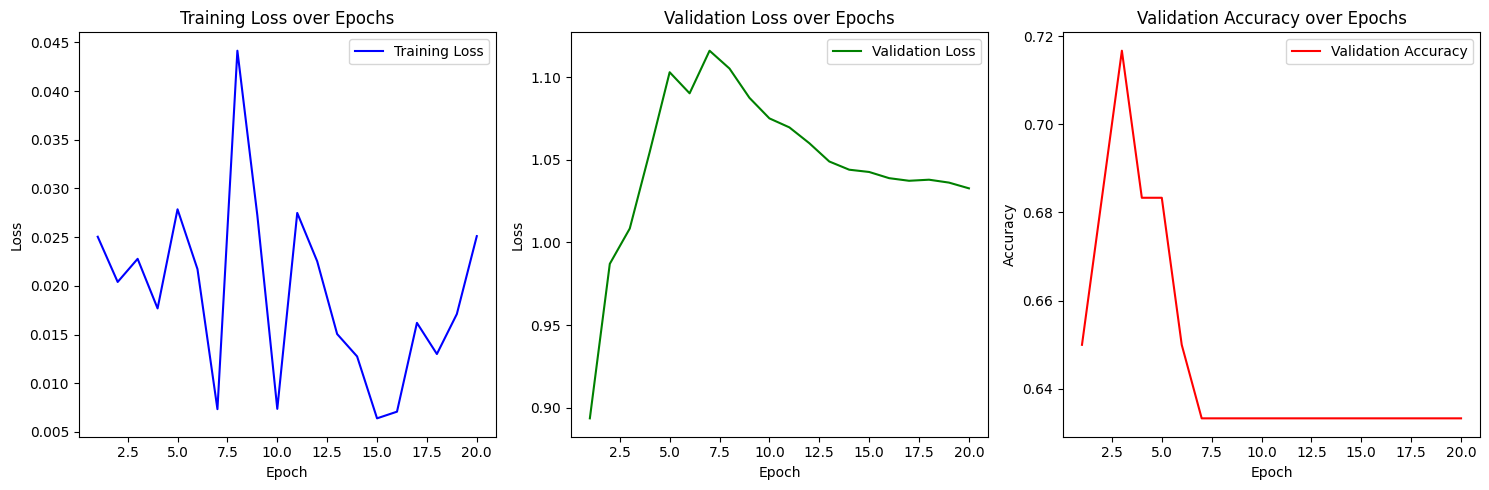

In [89]:
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Setup optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Create ReduceLROnPlateau scheduler: monitor validation loss, reduce LR by factor 0.1 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
train_losses = []
val_accuracies = []
val_losses = []  # To store validation loss for scheduler

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    correct = total = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = correct / total

    # Step scheduler based on validation loss
    scheduler.step(val_loss)

    train_losses.append(epoch_loss)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {epoch_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Accuracy: {val_acc:.4f} - "
          f"LR: {current_lr:.6f}")

# Plotting training and validation loss, and validation accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, val_losses, 'g-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
